## Import

In [1]:
import random
import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from sklearn.preprocessing import LabelEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce RTX 3090'

In [4]:
torch.cuda.is_available()

True

In [5]:
torch.__version__

'2.0.1+cu118'

In [6]:
# torch.cuda.empty_cache()

## Hyperparameter Setting

In [7]:
CFG = {
    'TRAIN_WINDOW_SIZE':120, # 90일치로 학습  초기는 90일이였음 
    'PREDICT_SIZE':21, # 21일치 예측
    'EPOCHS':100,
    'LEARNING_RATE':4.9000e-06,
    'BATCH_SIZE':4096,
    'SEED':41
}

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

### 데이터 불러오기

In [9]:
train_data = pd.read_csv('E:/LG/LG_data/LG/train.csv').drop(columns=['ID',"제품"])

In [10]:
train_data

,대분류,중분류,소분류,브랜드,쇼핑몰,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,...,2023-04-15,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24
0,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,S001-00001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0,0,0,0,0,...,2,0,2,0,2,2,1,0,0,0
2,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00010,0,0,0,0,0,...,10,6,4,4,4,0,0,0,0,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28889,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03798,S001-00001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28890,B002-C001-0003,B002-C002-0008,B002-C003-0042,B002-03799,S001-00001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
28891,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,S001-00001,0,0,0,0,0,...,2,4,1,0,0,0,4,0,2,0
28892,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-03799,S001-00001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
brand_keyword_cnt = pd.read_csv('E:/LG/LG_data/brand_keyword_cnt.csv')

# EDA

In [12]:
train_data.head(2)

,대분류,중분류,소분류,브랜드,쇼핑몰,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,...,2023-04-15,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24
0,B002-C001-0002,B002-C002-0007,B002-C003-0038,B002-00001,S001-00001,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,B002-C001-0003,B002-C002-0008,B002-C003-0044,B002-00002,S001-00001,0,0,0,0,0,...,2,0,2,0,2,2,1,0,0,0


In [13]:
train_data.isnull().sum()

대분류           0
중분류           0
소분류           0
브랜드           0
쇼핑몰           0
             ..
2023-04-20    0
2023-04-21    0
2023-04-22    0
2023-04-23    0
2023-04-24    0
Length: 484, dtype: int64

In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28894 entries, 0 to 28893
Columns: 484 entries, 대분류 to 2023-04-24
dtypes: int64(479), object(5)
memory usage: 106.7+ MB


In [15]:
train_data.describe()

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2023-04-15,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24
count,28894.000000,28894.000000,28894.000000,28894.000000,28894.000000,28894.000000,28894.000000,28894.000000,28894.000000,28894.000000,...,28894.000000,28894.000000,28894.000000,28894.000000,28894.000000,28894.000000,28894.000000,28894.000000,28894.000000,28894.000000
mean,38.163079,38.294386,40.030733,42.700768,43.352738,48.267806,43.990379,37.021389,36.971067,46.322281,...,9.920295,10.176507,12.681353,15.883505,14.136637,12.249567,11.490136,9.433446,8.518343,12.861667
std,390.594978,420.367341,331.892468,344.883319,341.598397,526.582285,469.866031,452.332080,452.845047,630.144024,...,105.131989,108.010472,117.078940,173.054027,179.006163,121.149269,127.556876,110.718062,82.644260,150.783720
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,6.000000,6.000000,8.000000,8.000000,8.000000,8.000000,6.000000,4.000000,6.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30112.000000,44820.000000,25644.000000,24876.000000,22848.000000,37632.000000,40560.000000,49024.000000,48064.000000,49932.000000,...,6069.000000,6069.000000,6372.000000,9412.000000,12320.000000,8000.000000,8512.000000,6848.000000,3960.000000,12324.000000


In [16]:
train_data.shape

(28894, 484)

In [17]:
train_data.size

13984696

TypeError: 'value' must be an instance of str or bytes, not a int

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 49660 (\N{HANGUL SYLLABLE SYO}) missing from current font.
  func(*args, **kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 54609 (\N{HANGUL SYLLABLE PING}) missing from current font.
  func(*args, **kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\events.py:93: UserWarning: Glyph 47792 (\N{HANGUL SYLLABLE MOL}) missing from current font.
  func(*args, **kwargs)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49660 (\N{HANGUL SYLLABLE SYO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54609 (\N{HANGUL SYLLABLE PING}) missing from cur

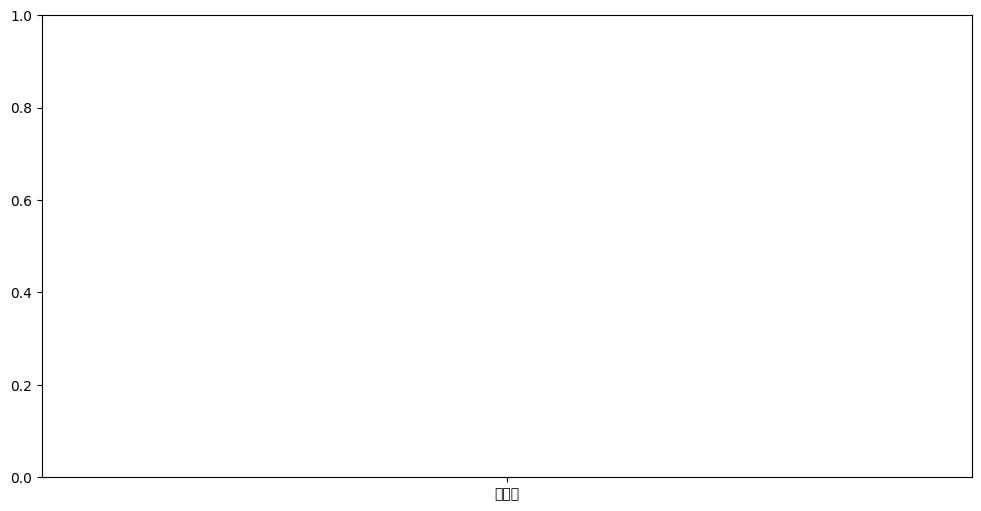

In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기 (예: 데이터프레임 이름을 train_data로 가정)
# train_data = pd.read_csv('데이터 파일 경로.csv')

# 분석할 특정 브랜드명 지정
target_brand = 'B002-00001'  # 분석하려는 브랜드명으로 변경

# 해당 브랜드의 판매량 데이터 추출
brand_sales = train_data[train_data['브랜드'] == target_brand].iloc[:, 4: 50]  # 4번째 열부터 판매량 데이터가 시작됨

# 날짜를 인덱스로 설정 (datetime 형식이 아닌 경우 필요하면 날짜 형식으로 변환)
# brand_sales.columns = pd.to_datetime(brand_sales.columns)

# 판매량 변화 시각화
plt.figure(figsize=(12, 6))
plt.plot(brand_sales.columns, brand_sales.values[0], marker='o', linestyle='-')
plt.title(f'{target_brand} 브랜드의 날짜별 판매량 변화')
plt.xlabel('날짜')
plt.ylabel('판매량')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
brand_sales.head()

,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,2022-01-10,...,2022-02-06,2022-02-07,2022-02-08,2022-02-09,2022-02-10,2022-02-11,2022-02-12,2022-02-13,2022-02-14,2022-02-15
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,1,0,1,1,1


In [ ]:
brand_sales.values[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1], dtype=int64)

C:\Users\User\AppData\Local\Temp\ipykernel_22192\2464688659.py:29: UserWarning: Glyph 45216 (\N{HANGUL SYLLABLE NAL}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_22192\2464688659.py:29: UserWarning: Glyph 51676 (\N{HANGUL SYLLABLE JJA}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_22192\2464688659.py:29: UserWarning: Glyph 54032 (\N{HANGUL SYLLABLE PAN}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_22192\2464688659.py:29: UserWarning: Glyph 47588 (\N{HANGUL SYLLABLE MAE}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_22192\2464688659.py:29: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from current font.
  plt.tight_layout()
C:\Users\User\AppData\Local\Temp\ipykernel_22192\2464688659.py:29: UserWarning: Glyph 48652 (\N{HANGUL SYLLABLE BEU}) missing from current font.
  plt.tight_layout()
C:

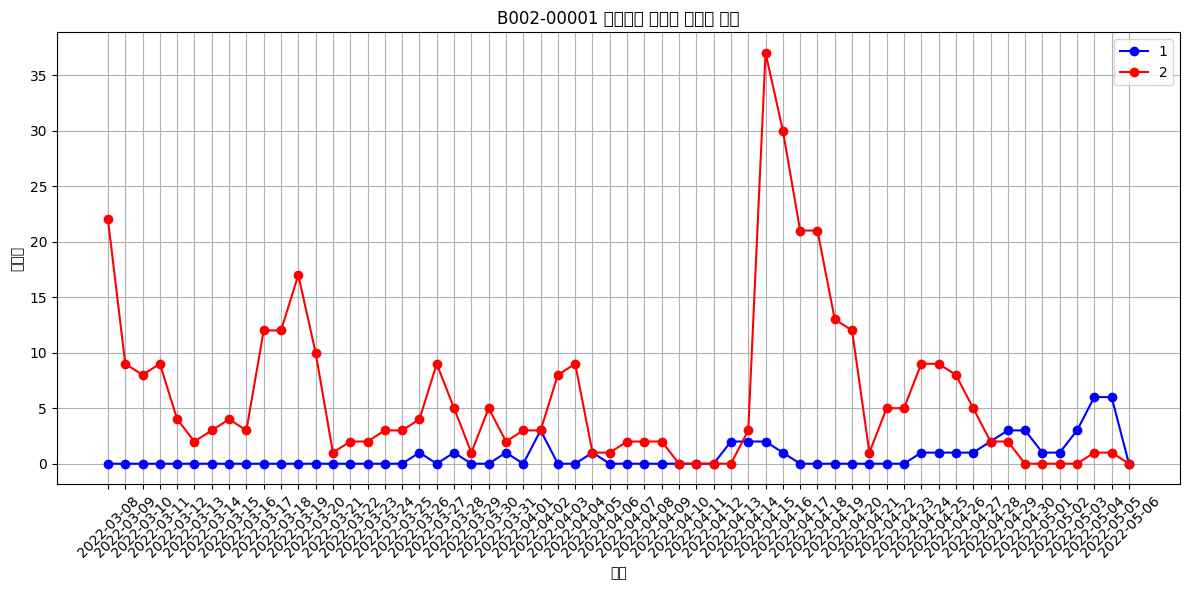

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 데이터 불러오기 (예: 데이터프레임 이름을 train_data로 가정)
# train_data = pd.read_csv('데이터 파일 경로.csv')

# 분석할 특정 브랜드명 지정
target_brand_1 = 'B002-00001'  # 분석하려는 브랜드명으로 변경
target_brand_2 = 'B002-00002'
target_brand_2 = 'B002-00003'

# 해당 브랜드의 판매량 데이터 추출
brand_sales_1 = train_data[train_data['브랜드'] == target_brand_1].iloc[:, 70: 130]
brand_sales_2 = train_data[train_data['브랜드'] == target_brand_2].iloc[:, 70: 130]  # 4번째 열부터 판매량 데이터가 시작됨

# 날짜를 인덱스로 설정 (datetime 형식이 아닌 경우 필요하면 날짜 형식으로 변환)
# brand_sales.columns = pd.to_datetime(brand_sales.columns)

# 판매량 변화 시각화
plt.figure(figsize=(12, 6))
plt.plot(brand_sales_1.columns, brand_sales_1.values[0], marker='o', linestyle='-', color = 'blue',label = "1")
plt.plot(brand_sales_2.columns, brand_sales_2.values[0], marker='o', linestyle='-', color =  'red', label = "2")
plt.title(f'{target_brand} 브랜드의 날짜별 판매량 변화')
plt.xlabel('날짜')
plt.ylabel('판매량')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
brand_keyword_cnt.head(2)

,브랜드,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,2022-01-06,2022-01-07,2022-01-08,2022-01-09,...,2023-03-26,2023-03-27,2023-03-28,2023-03-29,2023-03-30,2023-03-31,2023-04-01,2023-04-02,2023-04-03,2023-04-04
0,B002-00001,0.84131,0.91383,1.45053,2.42239,1.87119,1.58108,1.23295,1.17493,1.14592,...,0.31911,0.39164,0.37713,0.49318,0.07252,0.29010,0.31911,0.23208,0.33362,0.44966
1,B002-00002,12.64868,20.27850,15.33217,12.75021,13.56251,13.70757,11.93791,15.56425,14.08471,...,10.26979,11.96692,10.64693,10.41485,10.48738,9.48651,9.28343,10.42935,11.15462,11.38671


### 데이터 전처리

In [19]:
import pandas as pd

# 더 작은 값을 추가하여 분모가 0인 경우 방지하는 상수 정의
EPSILON = 1e-8

numeric_cols = train_data.columns[5:]

# 칵 column의 min 및 max 계산
min_values = train_data[numeric_cols].min(axis=1)
max_values = train_data[numeric_cols].max(axis=1)

# 각 행의 범위(max-min)를 계산하고, 범위가 0인 경우 EPSILON 더해주기
ranges = max_values - min_values + EPSILON
# min-max scaling 수행
scaled_data = (train_data[numeric_cols].subtract(min_values, axis=0)).div(ranges, axis=0)

# 스케일링된 데이터로 업데이트
train_data[numeric_cols] = scaled_data

# max와 min 값을 dictionary 형태로 저장
scale_min_dict = min_values.to_dict()
scale_max_dict = max_values.to_dict()


In [20]:
# ## 평균 분산 -> standersacle 

# ## 수학적 공식 : xi현재값 - x평균  / x표준편차


# numeric_cols = train_data.columns[4:]

# mean_value = train_data[numeric_cols].mean(axis =1)

# std_values = train_data[numeric_cols].std(axis =1)

# ranges = std_values
# print(ranges)

# scaled_data = (train_data[numeric_cols].subtract(mean_value, axis = 0)).div(ranges, axis=0)


# # 스케일링된 데이터로 업데이트
# train_data[numeric_cols] = scaled_data

# # max와 min 값을 dictionary 형태로 저장
# scale_mean_dict = mean_value.to_dict()
# scale_std_dict = std_values.to_dict()

In [27]:
# Label Encoding
label_encoder = LabelEncoder()
categorical_columns = ['대분류', '중분류', '소분류', '브랜드','쇼핑몰']

for col in categorical_columns:
    label_encoder.fit(train_data[col])
    train_data[col] = label_encoder.transform(train_data[col])

In [28]:
def make_train_data(data, train_size=CFG['TRAIN_WINDOW_SIZE'], predict_size=CFG['PREDICT_SIZE']):
    '''
    학습 기간 블럭, 예측 기간 블럭의 세트로 데이터를 생성
    data : 일별 판매량
    train_size : 학습에 활용할 기간
    predict_size : 추론할 기간
    '''
    num_rows = len(data)
    window_size = train_size + predict_size
    
    input_data = np.empty((num_rows * (len(data.columns) - window_size + 1), train_size, len(data.iloc[0, :5]) + 1))
    target_data = np.empty((num_rows * (len(data.columns) - window_size + 1), predict_size))
    
    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :5])
        sales_data = np.array(data.iloc[i, 5:])
        
        for j in range(len(sales_data) - window_size + 1):
            window = sales_data[j : j + window_size]
            temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
            input_data[i * (len(data.columns) - window_size + 1) + j] = temp_data
            target_data[i * (len(data.columns) - window_size + 1) + j] = window[train_size:]
    
    return input_data, target_data

In [29]:
def make_predict_data(data, train_size=CFG['TRAIN_WINDOW_SIZE']):
    '''
    평가 데이터(Test Dataset)를 추론하기 위한 Input 데이터를 생성
    data : 일별 판매량
    train_size : 추론을 위해 필요한 일별 판매량 기간 (= 학습에 활용할 기간)
    '''
    num_rows = len(data)
    
    input_data = np.empty((num_rows, train_size, len(data.iloc[0, :5]) + 1))
    
    for i in tqdm(range(num_rows)):
        encode_info = np.array(data.iloc[i, :5])
        sales_data = np.array(data.iloc[i, -train_size:])
        
        window = sales_data[-train_size : ]
        temp_data = np.column_stack((np.tile(encode_info, (train_size, 1)), window[:train_size]))
        input_data[i] = temp_data
    
    return input_data

In [30]:
train_data.tail()

,대분류,중분류,소분류,브랜드,쇼핑몰,2022-01-01,2022-01-02,2022-01-03,2022-01-04,2022-01-05,...,2023-04-15,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24
28889,2,7,43,2893,0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.00000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0
28890,2,7,41,2894,0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.00000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0
28891,2,7,43,2894,0,0.0,0.0,0.0,0.0,0.0,...,0.00813,0.01626,0.004065,0.000000,0.0,0.000000,0.01626,0.000000,0.008130,0.0
28892,2,7,43,2894,0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.00000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,0.000000,0.0
28893,2,7,43,2894,0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.00000,0.000000,0.035714,0.0,0.035714,0.00000,0.035714,0.071429,0.0


In [31]:
train_input, train_target = make_train_data(train_data)
test_input = make_predict_data(train_data)

100%|██████████| 28894/28894 [00:36<00:00, 782.62it/s]


In [32]:
data_len = len(train_input)
val_ratio = 0.1


val_len = int(data_len * val_ratio)


val_input = train_input[-val_len:]
val_target = train_target[-val_len:]

train_input = train_input[:-val_len]
train_target = train_target[:-val_len]


In [33]:
train_input.shape, train_target.shape, val_input.shape, val_target.shape, test_input.shape

((8945583, 120, 6),
 (8945583, 21),
 (993953, 120, 6),
 (993953, 21),
 (28894, 120, 6))

### Custom Dataset

In [34]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
        
    def __getitem__(self, index):
        if self.Y is not None:
            return torch.Tensor(self.X[index]), torch.Tensor(self.Y[index])
        return torch.Tensor(self.X[index])
    
    def __len__(self):
        return len(self.X)

In [35]:
train_dataset = CustomDataset(train_input, train_target)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(val_input, val_target)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

### 모델 선언

# Layer Normalization

In [46]:
import torch
import torch.nn as nn

class ImprovedModelWithCNN(nn.Module):
    def __init__(self, input_size=6, hidden_size=512, num_layers=2, output_size=CFG['PREDICT_SIZE'], dropout_prob=0.2):
        super(ImprovedModelWithCNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # 1D CNN 레이어 추가
        self.cnn = nn.Sequential(
            nn.Conv1d(input_size, hidden_size, kernel_size=20, padding=1, stride = 1),  # 1D 합성곱 레이어
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride = 1),  # 맥스 풀링 레이어
            nn.Conv1d(hidden_size, hidden_size, kernel_size=20, padding=1, stride = 1),  # 1D 합성곱 레이어
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride = 1),  # 맥스 풀링 레이어
            nn.Conv1d(hidden_size, hidden_size, kernel_size=20, padding=1, stride = 1),  # 1D 합성곱 레이어
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=5, stride = 1)  # 맥스 풀링 레이어
        )
        
        self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, batch_first=True)
        self.ln = nn.LayerNorm(hidden_size)  # Layer Normalization
        self.dropout = nn.Dropout(dropout_prob)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Linear(hidden_size // 2, output_size)
        )
        self.actv = nn.ReLU()

    def forward(self, x):
        batch_size = x.size(0)
        hidden = self.init_hidden(batch_size, x.device)

        # 1D CNN 레이어 적용
        x = self.cnn(x.permute(0, 2, 1)).permute(0, 2, 1)

        gru_out, hidden = self.gru(x, hidden)
        gru_out = self.dropout(gru_out)
        gru_out = self.ln(gru_out)  # Layer Normalization 적용

        last_output = gru_out[:, -1, :]

        output = self.actv(self.fc(last_output))

        return output.squeeze(1)

    def init_hidden(self, batch_size, device):
        return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)


In [47]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import math

# class MultiHeadAttention(nn.Module):
#     def __init__(self, num_heads, hidden_size):
#         super(MultiHeadAttention, self).__init__()
#         self.num_heads = num_heads
#         self.head_dim = hidden_size // num_heads

#         # Linear transformations for queries, keys, and values for each head
#         self.wq = nn.Linear(hidden_size, hidden_size)
#         self.wk = nn.Linear(hidden_size, hidden_size)
#         self.wv = nn.Linear(hidden_size, hidden_size)

#         # Linear transformation for concatenating heads
#         self.concat_head = nn.Linear(hidden_size, hidden_size)

#         # Scaled Dot-Product Attention
#         self.scaled_dot_product_attention = ScaledDotProductAttention()

#     def forward(self, query, key, value, mask=None):
#         # Linearly transform queries, keys, and values for each head
#         query = self.wq(query)
#         key = self.wk(key)
#         value = self.wv(value)

#         # Split queries, keys, and values into multiple heads
#         query = query.view(query.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
#         key = key.view(key.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
#         value = value.view(value.size(0), -1, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

#         # Apply Scaled Dot-Product Attention for each head
#         attn_output, attn_weights = self.scaled_dot_product_attention(query, key, value, mask)

#         # Concatenate the heads
#         attn_output = attn_output.permute(0, 2, 1, 3).contiguous().view(query.size(0), -1, self.num_heads * self.head_dim)
#         output = self.concat_head(attn_output)

#         return output, attn_weights

# class ScaledDotProductAttention(nn.Module):
#     def forward(self, query, key, value, mask=None):
#         scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(query.size(-1))
#         if mask is not None:
#             scores.masked_fill_(mask == 0, -1e9)  # Masked positions are set to a large negative value
#         attention_weights = F.softmax(scores, dim=-1)
#         output = torch.matmul(attention_weights, value)
#         return output, attention_weights

# class ImprovedModelWithMultiHeadAttention(nn.Module):
#     def __init__(self, input_size=5, hidden_size=512, num_layers=2, output_size=CFG['PREDICT_SIZE'], dropout_prob=0.2, num_heads=8):
#         super(ImprovedModelWithMultiHeadAttention, self).__init__()
#         self.hidden_size = hidden_size
#         self.num_layers = num_layers
#         self.num_heads = num_heads

#         # 1D CNN 레이어 추가
#         self.cnn = nn.Sequential(
#             nn.Conv1d(input_size, hidden_size, kernel_size=20, padding=1, stride=1),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=5, stride=1),
#             nn.Conv1d(hidden_size, hidden_size, kernel_size=20, padding=1, stride=1),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=5, stride=1),
#             nn.Conv1d(hidden_size, hidden_size, kernel_size=20, padding=1, stride=1),
#             nn.ReLU(),
#             nn.MaxPool1d(kernel_size=5, stride=1)
#         )

#         self.multi_head_attention = MultiHeadAttention(num_heads, hidden_size)

#         self.gru = nn.GRU(hidden_size, hidden_size, num_layers=num_layers, batch_first=True)
#         self.ln = nn.LayerNorm(hidden_size)
#         self.dropout = nn.Dropout(dropout_prob)
#         self.fc = nn.Sequential(
#             nn.Linear(hidden_size, hidden_size // 2),
#             nn.ReLU(),
#             nn.Linear(hidden_size // 2, output_size)
#         )
#         self.actv = nn.ReLU()

#     def forward(self, x):
#         batch_size = x.size(0)
#         hidden = self.init_hidden(batch_size, x.device)

#         # 1D CNN 레이어 적용
#         x = self.cnn(x.permute(0, 2, 1)).permute(0, 2, 1)

#         # Multi-Head Attention 적용
#         x, _ = self.multi_head_attention(x, x, x)

#         gru_out, hidden = self.gru(x, hidden)
#         gru_out = self.dropout(gru_out)
#         gru_out = self.ln(gru_out)

#         last_output = gru_out[:, -1, :]

#         output = self.actv(self.fc(last_output))

#         return output.squeeze(1)

#     def init_hidden(self, batch_size, device):
#         return torch.zeros(self.num_layers, batch_size, self.hidden_size, device=device)


### 모델 학습

In [48]:
def train(model, optimizer, train_loader, val_loader, device, scheduler=None):
    model.to(device)
    criterion = nn.MSELoss().to(device)
    best_loss = float('inf')
    best_model = None
    early_stopping_counter = 0
    max_early_stopping = 10  # Max number of consecutive epochs with increasing validation loss
    
    for epoch in range(1, CFG['EPOCHS'] + 1):
        model.train()
        train_loss = []
        train_mae = []

        for X, Y in tqdm(iter(train_loader)):
            X = X.to(device)
            Y = Y.to(device)

            optimizer.zero_grad()

            output = model(X)
            loss = criterion(output, Y)

            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())


        
        val_loss = validation(model, val_loader, criterion, device)
        print(f'Epoch : [{epoch}] Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}]')

        if scheduler is not None:
            scheduler.step(val_loss)  # Update learning rate based on scheduler's policy
        
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= max_early_stopping:
                print(f'Early stopping triggered at epoch {epoch}')
                break

    return best_model


In [49]:
def validation(model, val_loader, criterion, device):
    model.eval()
    val_loss = []
    
    with torch.no_grad():
        for X, Y in tqdm(iter(val_loader)):
            X = X.to(device)
            Y = Y.to(device)
            
            output = model(X)
            loss = criterion(output, Y)
            
            val_loss.append(loss.item())
    return np.mean(val_loss)

## Run !!

In [50]:
import torch.optim.lr_scheduler as lr_scheduler

model = ImprovedModelWithCNN() # BaseModel() 
optimizer = torch.optim.RAdam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.7, verbose=True)
infer_model = train(model, optimizer, train_loader, val_loader, device, scheduler)


 11%|█         | 230/2184 [03:52<32:54,  1.01s/it] 


KeyboardInterrupt: 

# 1차 : id, 제품 추가해서 돌리기 시도 - > 2차에 해 볼것은 비슷한 특징 끼리 묶을 생각임 -> 3차 90 일로 줄이고 레이어 늘리고 커널 줄이고시도 

## learing rate를 올리고 학습을 진행 //// embedding 공부를 진행하자. 
## ///  다음으로는 과적합의 이유가 모델이 너무 train에 일반화된 걸 수도 있지만 그것을 극복하기 위해서 대회에서는 날짜 수를 많이 가져가서 학습진행 시도 
## ///또는 너가 말한데대로 일정한 기준을 잡고 모델을 학습을 진행하는 거지 이유는 기준이 모델의척도가 될 수 있음 
## // 또는 모델이 너무 복잡해서 일 수도 있으니까 drop out을 올리자.
## //// Leaky ReLU (LReLU) 이거 적용하고 standarscale적용해서 진행해보자-> 이번에는 그냥 모델의 층수를 늘려서 진행하는것임

## 모델 추론

In [ ]:
test_dataset = CustomDataset(test_input, None)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
def inference(model, test_loader, device):
    predictions = []
    
    with torch.no_grad():
        for X in tqdm(iter(test_loader)):
            X = X.to(device)
            
            output = model(X)
            
            # 모델 출력인 output을 CPU로 이동하고 numpy 배열로 변환
            output = output.cpu().numpy()
            
            predictions.extend(output)
    
    return np.array(predictions)

In [ ]:
pred = inference(infer_model, test_loader, device)

100%|██████████| 4/4 [00:02<00:00,  1.37it/s]


In [ ]:
# 추론 결과를 inverse scaling
for idx in range(len(pred)):
    pred[idx, :] = pred[idx, :] * (scale_max_dict[idx] - scale_min_dict[idx]) + scale_min_dict[idx]
    
# 결과 후처리
pred = np.round(pred, 0).astype(int)

In [ ]:
# # 추론 결과를 inverse scaling
# for idx in range(len(pred)):
#     pred[idx, :] = pred[idx, :] * scale_std_dict[idx]  + scale_mean_dict[idx]
    
# # 결과 후처리
# pred = np.round(pred, 0).astype(int)


In [ ]:
pred.shape

(15890, 21)

## Submission

In [ ]:
submit = pd.read_csv('E:/LG/LG_data/sample_submission.csv')
submit.head()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
submit.iloc[:,1:] = pred
submit.head()

,ID,2023-04-05,2023-04-06,2023-04-07,2023-04-08,2023-04-09,2023-04-10,2023-04-11,2023-04-12,2023-04-13,...,2023-04-16,2023-04-17,2023-04-18,2023-04-19,2023-04-20,2023-04-21,2023-04-22,2023-04-23,2023-04-24,2023-04-25
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,0
2,2,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1
3,3,1,1,1,1,1,1,1,1,1,...,1,1,2,2,2,2,2,2,2,2
4,4,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [ ]:
submit.to_csv('E:/LG/LG_data/models/037_ReLU_layer3.csv', index=False)

In [ ]:
### 시도할 경우의 수는 임베딩이 안된다 후하 그럼 이제는 다른 것을 적용해보자  //음... 

# 1. 학습률 다르게 해보기 

# 1. 기준 조건에서 150 일로 증가  
# 2. 다른 특징 추가로 넣기
# 3. 